In [38]:
import pandas as pd
import numpy as np
#default to .3f for pandas floats
pd.options.display.float_format = '{:.3f}'.format

models = {}
n_jobs=15

# Decision Trees

We were able to extract some signal from our dataset during the logistic regression exploration and have settled on three features to use:
- Ethnicity
- Gender
- Search Reason
- Area Command

We will now explore these in a decision tree model and see if we can boost performance.

# Load and Split Data

In [39]:
df_init = pd.read_csv("../data/merged_data.csv", index_col=0)
df_init.info()

label = "Search Result"
s_labels = df_init[label]
df_init = df_init.drop(label, axis=1)
df_init = df_init.drop("ward_code", axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74409 entries, 0 to 74408
Columns: 224 entries, ward_code to employment_count_log
dtypes: float64(44), int64(176), object(4)
memory usage: 127.7+ MB


In [40]:
from sklearn.model_selection import train_test_split

X_train_init, X_test_init, y_train, y_test = train_test_split(df_init.copy(), s_labels.copy(), random_state=42, test_size=0.25)

# Decsision Tree

We'll train a basic decision tree model using a grid search to find the best hyperparameters.

In [41]:
#setup

def list_onehot_columns(df, column_prefix):
    """returns a list of columns from a dataframe that begin wih the given column_prefix"""
    return df.columns[df.columns.str.contains(f"{column_prefix}.*", regex=True)].to_list()

cols = []

cols += list_onehot_columns(X_train_init, "Nominal Ethnicity")
cols += list_onehot_columns(X_train_init, "Search Reason")
cols += list_onehot_columns(X_train_init, "Area Command")
cols += ["Nominal Gender_Male"]

X_train = X_train_init[cols]

In [42]:
grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": range(3,10),
    "min_samples_split": np.arange(0,1.1,0.1).tolist(),
    "min_samples_leaf": np.arange(0,1.1,0.1).tolist(),
    "class_weight": ["balanced", None]
}

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier()

clf = GridSearchCV(estimator=estimator, param_grid=grid, n_jobs=n_jobs, verbose=3, scoring="roc_auc")
clf.fit(X_train, y_train)

Fitting 5 folds for each of 6776 candidates, totalling 33880 fits
/home/adam/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning:

One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]



GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=15,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(3, 10),
                         'min_samples_leaf': [0.0, 0.1, 0.2,
                                              0.30000000000000004, 0.4, 0.5,
                                              0.6000000000000001,
                                              0.7000000000000001, 0.8, 0.9,
                                              1.0],
                         'min_samples_split': [0.0, 0.1, 0.2,
                                               0.30000000000000004, 0.4, 0.5,
                                               0.6000000000000001,
                                               0.7000000000000001, 0.8, 0.9,
                                               1.0],
                         'splitter': ['best', 'random']},
             scoring='roc_auc', verbose=3

In [44]:
clf.best_score_

0.5268858764553671

In [45]:
clf.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1,
 'splitter': 'best'}

The AUC score achieved is significantly worse than that achieved by logistic regression (0.624) and is barely above 0.5, telling us the model is is perfoming only slightly better than a coin flip.

We can investigate the metrics of this best decision tree model further to find out what is happening. 

In [46]:
df_cv = pd.DataFrame(clf.cv_results_)

df_cv.mean_test_score.value_counts()

0.500    1680
0.519     728
0.527     336
0.523      56
Name: mean_test_score, dtype: int64

The grid search is producing a small number of different AUC scores. 336 models produced the best score of 0.527 suggesting that only a small number of features are having any impact.

The "best model" in this case will be the first model in the grid search that produced that score, it is plotted below. The Gini impurity on every node is 0.5 +/- 0.004, i.e. the model is strugglingperate the labels based on these features.

from sklearn.tree import plot_tree

plot_tree(best_model, feature_names=X_train.columns)

[Text(111.60000000000001, 190.26, 'Search Reason_Drugs <= 0.5\ngini = 0.5\nsamples = 55806\nvalue = [27903.0, 27903.0]'),
 Text(55.800000000000004, 135.9, 'gini = 0.496\nsamples = 11677\nvalue = [6211.823, 5167.844]'),
 Text(167.4, 135.9, 'Nominal Gender_Male <= 0.5\ngini = 0.5\nsamples = 44129\nvalue = [21691.177, 22735.156]'),
 Text(111.60000000000001, 81.53999999999999, 'gini = 0.499\nsamples = 5818\nvalue = [3012.901, 2722.346]'),
 Text(223.20000000000002, 81.53999999999999, 'Nominal Ethnicity_White Scottish <= 0.5\ngini = 0.499\nsamples = 38311\nvalue = [18678.276, 20012.81]'),
 Text(167.4, 27.180000000000007, 'gini = 0.497\nsamples = 6327\nvalue = [2984.103, 3485.778]'),
 Text(279.0, 27.180000000000007, 'gini = 0.5\nsamples = 31984\nvalue = [15694.173, 16527.032]')]

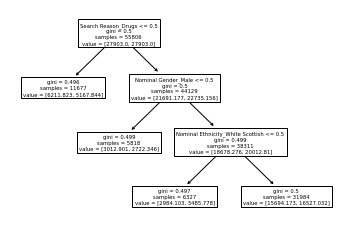

In [47]:
Visualising the ROC curve, it is as we expect given this sort of outcome, with performance barely above 50% at all thresholds. Optimizing the threshold will not siginificantly improve model performance.

In [49]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve
import plotly.graph_objects as go

best_model = DecisionTreeClassifier(**clf.best_params_)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_train)

roc_curve_fig = None
roc_curve_fig = go.Figure()
roc_curve_fig.update_layout(
    autosize=False,
    width=width,
    height=height,
    xaxis_title="False Positive Rate (Sensitivty)",
    yaxis_title="True Positive Rate (1-Precision)",
    title=f"ROC Curve",
    yaxis_range=[0,1],
    xaxis_range=[0,1],
    legend=dict(
        x=0.78,
        y=0.1,
        title_text='Data'
        )
    )

roc_curve_fig.add_trace(go.Scatter(x=fpr, y=tpr, name="ROC", mode="lines"))
roc_curve_fig.add_trace(go.Scatter(x=[0,1], y =[0,1], name="Baseline", mode="lines", line=dict(color = 'rgba(50,50,50,0.2)')))

The confusion matrix shows us that the model is mostly just predicting positive results, and predicting much fewer negatives. The errors are not random: we will see low a false negative rate and high true positive rate because the model is rarely predicting negative. The false positive rate and true positive rate will both be high because the model predicts positive most of the time, fairly randomly.

FPR: 0.67 TPR: 0.72 FNR: 0.28 TNR: 0.33
Precision: 0.37
NPV: 0.68


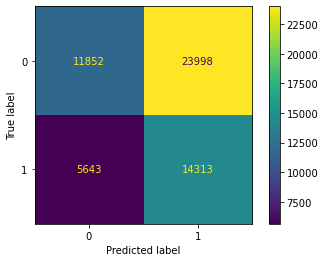

In [62]:
plot_confusion_matrix(best_model, X_train, y_train)

tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

condition_neg = tn + fp
condition_pos = tp + fn

fpr = fp / conditon_neg
tpr = tp / condition_pos
fnr = fn / condition_pos
tnr = tn / condition_neg

print ("FPR: {:.2f} TPR: {:.2f} FNR: {:.2f} TNR: {:.2f}".format(fpr, tpr, fnr, tnr))

print ("Precision: {:.2f}".format(tp / (tp + fp)))
print ("NPV: {:.2f}".format(tn / (tn + fn)))

The model precision is 0.37, this is roughly equal to prevelance. Given we know the model is struggling to seperate the classes, and leans towards making positive predicitons most of the time, the fact these numbers are almost equal confirms that the model is making predictions largely at random.

# Summary

A decision tree is not a good model here at performs worse than the logistic regression. It seems there are no clear boundaries between the labels in any of the features and that makes it difficult for a decision tree to make predictions. Logistic regression may be performing better because it is able to find small correlations that the decision tree can't.